In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd

import keras
from keras.utils import np_utils
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.


In [2]:
face_recog_data = pd.read_csv('fer2013.csv')
face_recog_data.head()

train_data = face_recog_data[["emotion", "pixels"]][face_recog_data["Usage"] == "Training"]
test_data = face_recog_data[["emotion", "pixels"]][face_recog_data["Usage"] == "PublicTest"]

#loading training data
training_target_values = np.array(train_data['emotion'])
training_target_values = training_target_values.astype(np.float32)
training_input_face_images = np.vstack((train_data['pixels'].apply(lambda pixel : np.fromstring(pixel, sep=' '))))
training_input_face_images = np.reshape(training_input_face_images, (training_input_face_images.shape[0], 48, 48))
training_input_face_images = training_input_face_images.astype(np.float32)
training_input_face_images = training_input_face_images

#loading test data
testing_target_values = np.array(test_data['emotion'])
testing_target_values = testing_target_values.astype(np.float32)
testing_input_face_images = np.vstack((test_data['pixels'].apply(lambda pixel : np.fromstring(pixel, sep=' '))))
testing_input_face_images = np.reshape(testing_input_face_images, (testing_input_face_images.shape[0], 48, 48))
testing_input_face_images = testing_input_face_images.astype(np.float32)
testing_input_face_images = testing_input_face_images


In [3]:
print(training_input_face_images.shape, training_target_values.shape)
print(testing_input_face_images.shape, testing_target_values.shape)

(28709, 48, 48) (28709,)
(3589, 48, 48) (3589,)


In [4]:
#data_length = 28709
#split = int(data_length * 0.8)



X_train = training_input_face_images
X_val = testing_input_face_images

y_train = np_utils.to_categorical(training_target_values[:])
y_val = np_utils.to_categorical(training_target_values)

#print(X_train.shape, X_val.shape)
#print(y_train.shape, y_val.shape)

Text(0.5,1,'[ 1.  0.  0.  0.  0.  0.  0.]')

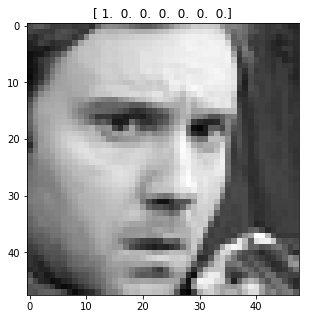

In [5]:
plt.figure(figsize=[5, 5])
plt.imshow(X_train[0], cmap='gray')
plt.title(y_train[0])

In [6]:
X_train = X_train.reshape(-1, 48, 48, 1)
#X_val = X_val.reshape(-1, 48, 48, 1)
X_test = testing_input_face_images.reshape(-1, 48,48, 1)
y_test = testing_target_values
y_test = np_utils.to_categorical(testing_target_values)
print(y_test.shape, X_test.shape)

(3589, 7) (3589, 48, 48, 1)


In [7]:
X_train = X_train.astype('float32')
#X_val = X_val.astype('float32')
X_test = X_test.astype('float32')
#X_train = X_train/255.0
#X_val = X_val/255.0
#X_test = X_test/255.0

In [8]:
print(y_train[:5])

[[ 1.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.]]


In [9]:
batch_size = 128
epochs = 40
num_classes = 7

In [10]:
model = Sequential()

#Deep model with less number of layers, lesser max-pools and small dense layers
#1st convolution layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Dropout(0.5))


model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.5))


model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.5))


model.add(Flatten())
 
#fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.75))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [11]:
model.compile(loss=keras.losses.categorical_crossentropy, 
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 46, 46, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 46, 46, 32)        128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 46, 46, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 44, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 44, 44, 64)        256       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 42, 42, 64)        36928     
_________________________________________________________________
batch_normalization_3 (Batch (None, 42, 42, 64)        256       
__________

In [13]:
from keras.callbacks import ModelCheckpoint

In [14]:
checkpointer = ModelCheckpoint(filepath='face_model.h5', verbose=1, save_best_only=True)

train_model = model.fit(X_train, y_train,
                    batch_size=batch_size,epochs=epochs,
                    verbose=1,
                    validation_data=(X_test, y_test),
                    callbacks=[checkpointer])

Train on 28709 samples, validate on 3589 samples
Epoch 1/40
28709/28709 [==============================] - 99s - loss: 2.4642 - acc: 0.1985 - val_loss: 1.8258 - val_acc: 0.2494
Epoch 2/40
28709/28709 [==============================] - 83s - loss: 1.8820 - acc: 0.2339 - val_loss: 1.8021 - val_acc: 0.2494
Epoch 3/40
28709/28709 [==============================] - 83s - loss: 1.8253 - acc: 0.2477 - val_loss: 1.7982 - val_acc: 0.2494
Epoch 4/40
28709/28709 [==============================] - 83s - loss: 1.7889 - acc: 0.2584 - val_loss: 1.7447 - val_acc: 0.2831
Epoch 5/40
28709/28709 [==============================] - 71s - loss: 1.7432 - acc: 0.2851 - val_loss: 1.6837 - val_acc: 0.2948
Epoch 6/40
28709/28709 [==============================] - 68s - loss: 1.6933 - acc: 0.3206 - val_loss: 1.6431 - val_acc: 0.3394
Epoch 7/40
28709/28709 [==============================] - 69s - loss: 1.6432 - acc: 0.3441 - val_loss: 1.5644 - val_acc: 0.3826
Epoch 8/40
28709/28709 [==============================]

28709/28709 [==============================] - 68s - loss: 1.2217 - acc: 0.5365 - val_loss: 1.1609 - val_acc: 0.5614
Epoch 30/40
28709/28709 [==============================] - 68s - loss: 1.2119 - acc: 0.5411 - val_loss: 1.1534 - val_acc: 0.5701
Epoch 31/40
28709/28709 [==============================] - 68s - loss: 1.1929 - acc: 0.5476 - val_loss: 1.1765 - val_acc: 0.5508
Epoch 32/40
28709/28709 [==============================] - 74s - loss: 1.1920 - acc: 0.5455 - val_loss: 1.1631 - val_acc: 0.5600
Epoch 33/40
28709/28709 [==============================] - 83s - loss: 1.1857 - acc: 0.5523 - val_loss: 1.1792 - val_acc: 0.5542
Epoch 34/40
28709/28709 [==============================] - 83s - loss: 1.1670 - acc: 0.5585 - val_loss: 1.1644 - val_acc: 0.5584
Epoch 35/40
28709/28709 [==============================] - 83s - loss: 1.1553 - acc: 0.5614 - val_loss: 1.1407 - val_acc: 0.5706
Epoch 36/40
28709/28709 [==============================] - 84s - loss: 1.1513 - acc: 0.5633 - val_loss: 1.112

In [15]:
model_json = model.to_json()
with open("face_model.json", "w") as json_file:
    json_file.write(model_json)

In [16]:
train_score = model.evaluate(X_train, y_train, verbose=0)
print('Train loss:', train_score[0])
print('Train accuracy:', 100*train_score[1])
 
test_score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', test_score[0])
print('Test accuracy:', 100*test_score[1])

Train loss: 0.974687343087
Train accuracy: 63.1996934763
Test loss: 1.11034730039
Test accuracy: 58.4285316248


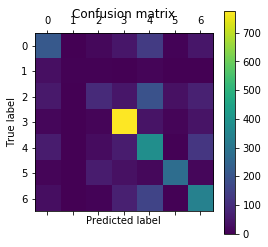

In [35]:
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_test, verbose=0)
ypredtemp = np.array([np.argmax(ypred[i]) for i in range(ypred.shape[0])])
ytemp = np.array([np.argmax(y_test[i]) for i in range(ypred.shape[0])])

cnf_matrix = confusion_matrix(ytemp, ypredtemp)
np.set_printoptions(precision=2)
class_names = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

plt.figure()
plt.matshow(cnf_matrix)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()